In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import joblib

In [2]:
# Load the dataset
df = pd.read_csv("new_wavelet_features.csv")

In [3]:
df.head()

,variance,skewness,kurtosis,entropy,class
0,18825.794527,-0.056914,0.018073,-0.006237,1
1,6841.258239,0.080827,0.148184,0.000645,1
2,14475.979899,0.004668,-0.027246,-0.000410,1
3,13457.590618,0.005749,0.011882,0.019889,1
4,9374.138184,-0.119408,-0.034655,0.003340,1


In [4]:
df.shape

(840, 5)

In [5]:
# Separate features and labels
X = df.drop(columns=["class"])
y = df["class"]

In [6]:
# Split the dataset into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66)

In [7]:
# Print the sizes of the training and testing sets
print("Size of X_train:", len(X_train))
print("Size of X_test:", len(X_test))
print("Size of y_train:", len(y_train))
print("Size of y_test:", len(y_test))


Size of X_train: 588
Size of X_test: 252
Size of y_train: 588
Size of y_test: 252


In [8]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [10]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_train_scaled)
    wcss.append(kmeans.inertia_)

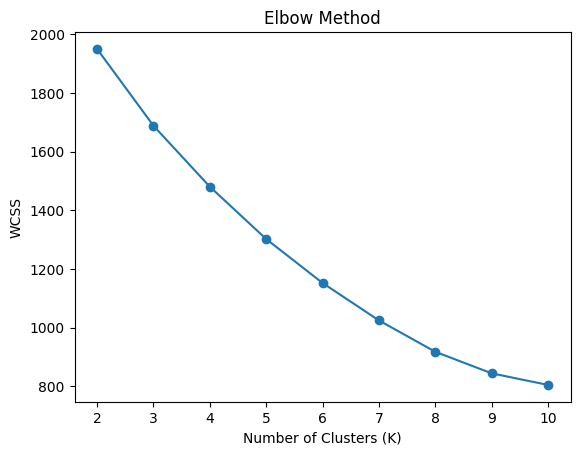

In [11]:
# Plot the Elbow Method graph
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()


In [12]:
# Choose the optimal K based on the Elbow Method
optimal_k = np.argmin(np.diff(wcss)) + 2
print("Optimal number of clusters (K) using Elbow Method:", optimal_k)

Optimal number of clusters (K) using Elbow Method: 2


In [13]:
# Perform K-means clustering with optimal K on the training set
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels_train = kmeans.fit_predict(X_train_scaled)

In [14]:
# Calculate silhouette score on the testing set
silhouette_avg = silhouette_score(X_test_scaled, kmeans.predict(X_test_scaled))
print("Silhouette Score on testing set:", silhouette_avg)


Silhouette Score on testing set: 0.2233676905099556


In [15]:
# Assign labels to clusters based on majority voting on the training set
cluster_labels_df_train = pd.DataFrame({"cluster": cluster_labels_train, "class": y_train})
cluster_labels_df_train["predicted_class"] = cluster_labels_df_train.groupby("cluster")["class"].transform(lambda x: x.mode()[0])


In [16]:
# Predict cluster labels for the testing set
cluster_labels_test = kmeans.predict(X_test_scaled)

In [17]:
# Assign labels to clusters based on majority voting on the testing set
cluster_labels_df_test = pd.DataFrame({"cluster": cluster_labels_test, "class": y_test})
cluster_labels_df_test["predicted_class"] = cluster_labels_df_test.groupby("cluster")["class"].transform(lambda x: x.mode()[0])

In [18]:
# Evaluate accuracy on the testing set
accuracy = accuracy_score(y_test, cluster_labels_df_test["predicted_class"])
print("Accuracy on testing set:", accuracy)

Accuracy on testing set: 0.746031746031746


In [19]:
# Evaluate accuracy on the training set
accuracy_train = accuracy_score(y_train, cluster_labels_df_train["predicted_class"])
print("Accuracy on training set:", accuracy_train)


Accuracy on training set: 0.7227891156462585


In [20]:
# Save the trained KMeans model
joblib.dump(kmeans, 'kmeans_model.pkl')

['kmeans_model.pkl']

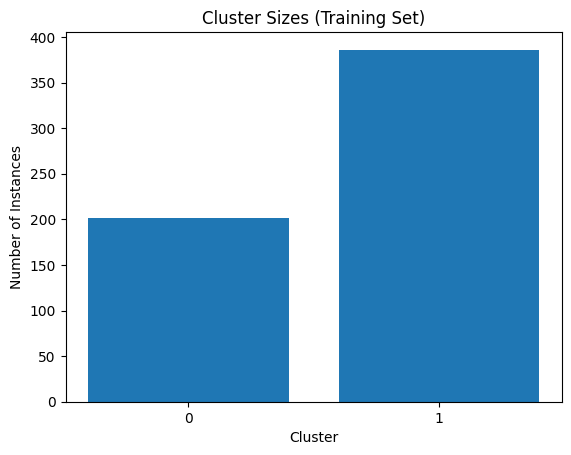

In [21]:
# Plot histogram of cluster sizes
plt.hist(cluster_labels_train, bins=range(optimal_k+1), align='left', rwidth=0.8)
plt.title('Cluster Sizes (Training Set)')
plt.xlabel('Cluster')
plt.ylabel('Number of Instances')
plt.xticks(range(optimal_k))
plt.show()


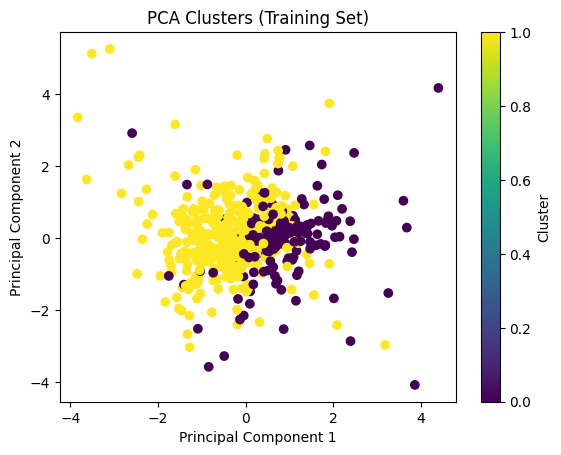

In [22]:
# Plot scatter plot of the clusters using PCA on the training set
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=cluster_labels_train, cmap='viridis')
plt.title('PCA Clusters (Training Set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

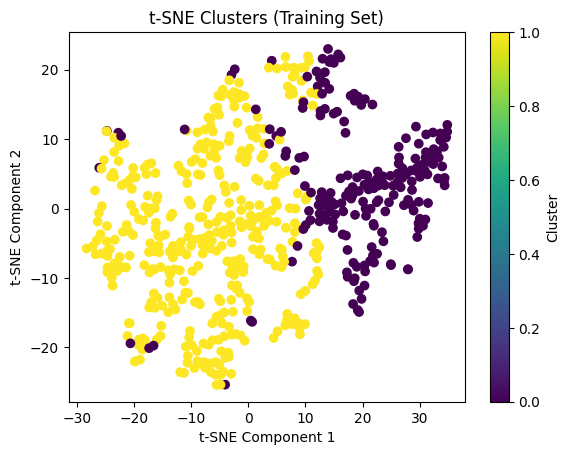

In [23]:
# Plot scatter plot of the clusters using t-SNE on the training set
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=cluster_labels_train, cmap='viridis')
plt.title('t-SNE Clusters (Training Set)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

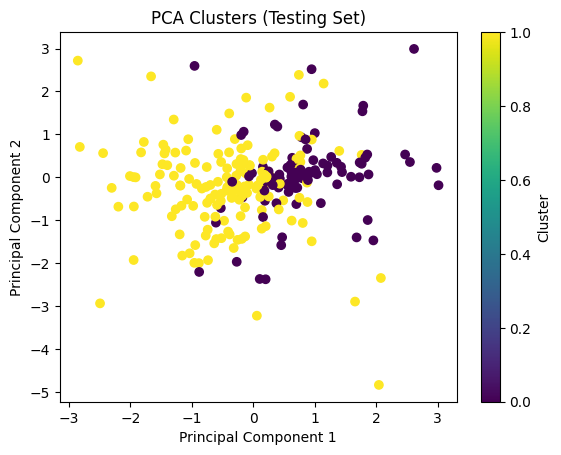

In [24]:
# Plot scatter plot of the clusters using PCA on the testing set
X_test_pca = pca.transform(X_test_scaled)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=cluster_labels_test, cmap='viridis')
plt.title('PCA Clusters (Testing Set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

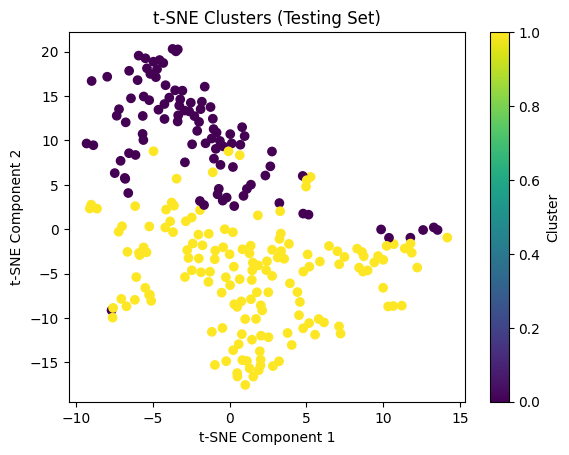

In [25]:
# Plot scatter plot of the clusters using t-SNE on the testing set
X_test_tsne = tsne.fit_transform(X_test_scaled)
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=cluster_labels_test, cmap='viridis')
plt.title('t-SNE Clusters (Testing Set)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [26]:
# Randomly select 5 samples from the testing set
random_samples = X_test.sample(5, random_state=42)

# Predict the cluster labels for the random samples
random_samples_scaled = scaler.transform(random_samples)
random_samples_cluster_labels = kmeans.predict(random_samples_scaled)

# Assign majority class to each cluster based on training set
predicted_classes = []
for cluster_label in random_samples_cluster_labels:
    majority_class = cluster_labels_df_train[cluster_labels_df_train['cluster'] == cluster_label]['predicted_class'].mode()[0]
    predicted_classes.append(majority_class)

# Compare predicted classes with actual classes
actual_classes = y_test[random_samples.index]

for i, (index, sample) in enumerate(random_samples.iterrows()):
    print(f"Sample {i+1}:")
    print("Features:", sample.values)
    print("Actual Class:", actual_classes[index])
    print("Predicted Class:", predicted_classes[i])
    print()


Sample 1:
Features: [ 1.41915847e+04 -1.08007812e-02 -3.92122396e-02 -8.82161458e-03]
Actual Class: 1
Predicted Class: 1

Sample 2:
Features: [1.46763712e+04 4.81770833e-02 6.80078125e-02 2.90364583e-03]
Actual Class: 0
Predicted Class: 0

Sample 3:
Features: [ 3.27045942e+04 -8.78906250e-04  1.45182292e-03 -8.39843750e-04]
Actual Class: 0
Predicted Class: 0

Sample 4:
Features: [1.21004098e+04 4.42773438e-02 1.30924479e-02 8.00781250e-04]
Actual Class: 0
Predicted Class: 1

Sample 5:
Features: [ 2.56662986e+04 -1.24023437e-02  1.49739583e-04  1.95312500e-05]
Actual Class: 0
Predicted Class: 0



In [42]:
from sklearn.metrics import accuracy_score

# Ask the user to input values for each feature
variance = float(input("Enter variance: "))
skewness = float(input("Enter skewness: "))
kurtosis = float(input("Enter kurtosis: "))
entropy = float(input("Enter entropy: "))

# Create a DataFrame with the user input
user_input = pd.DataFrame([[variance, skewness, kurtosis, entropy]], columns=['variance', 'skewness', 'kurtosis', 'entropy'])

# Scale the user input using the loaded scaler
user_input_scaled = scaler.transform(user_input)

# Predict the cluster label for the user input
user_cluster_label = kmeans.predict(user_input_scaled)[0]

# Retrieve majority class assigned to the predicted cluster
user_predicted_class = cluster_labels_df_train[cluster_labels_df_train['cluster'] == user_cluster_label]['predicted_class'].mode()[0]

print("Predicted Class:", user_predicted_class)

# Calculate accuracy for the predicted class compared to actual classes
actual_classes_predicted_cluster = y_test[cluster_labels_df_test['cluster'] == user_cluster_label]
accuracy = accuracy_score(actual_classes_predicted_cluster, [user_predicted_class] * len(actual_classes_predicted_cluster))

print("Accuracy for Predicted Class:", accuracy)


Predicted Class: 1
Accuracy for Predicted Class: 0.7096774193548387
